#**Content Based Recommender System**

**Libraries**

In [ ]:
pip install gensim

In [ ]:
pip install umap-learn

In [ ]:
pip install tbb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import json
import pandas as pd
import numpy as np
import nltk
from tqdm import tqdm
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import random
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import matplotlib.pyplot as plt
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

#**Read The Files**

In [ ]:
with open('/content/drive/MyDrive/hepsiburada/hepsi/data/events.json','rb') as f:
    data = json.load(f)
df = pd.DataFrame(data['events'])
df.head()

,event,sessionid,eventtime,price,productid
0,cart,a0655eee-1267-4820-af21-ad8ac068ff7a,2020-06-01T08:59:16.406Z,14.48,HBV00000NVZE8
1,cart,d2ea7bd3-9235-4a9f-a9ea-d7f296e71318,2020-06-01T08:59:46.580Z,49.90,HBV00000U2B18
2,cart,5e594788-78a0-44dd-8e66-37022d48f691,2020-06-01T08:59:33.308Z,1.99,OFIS3101-080
3,cart,fdfeb652-22fa-4153-b9b5-4dfa0dcaffdf,2020-06-01T08:59:31.911Z,2.25,HBV00000NVZBW
4,cart,9e9d4f7e-898c-40fb-aae9-256c40779933,2020-06-01T08:59:33.888Z,9.95,HBV00000NE0T4


In [ ]:
df.shape

(387656, 5)

#**events.json has very few missing values.**

In [ ]:
df.isna().mean()

event        0.000000
sessionid    0.000000
eventtime    0.000000
price        0.000015
productid    0.000015
dtype: float64

In [ ]:
with open('/content/drive/MyDrive/hepsiburada/hepsi/data/meta.json','rb') as f:
    data2 = json.load(f)

In [ ]:
df2 = pd.DataFrame(data2['meta'])
df2.head()

,productid,brand,category,subcategory,name
0,HBV00000AX6LR,Palette,Kişisel Bakım,Saç Bakımı,Palette Kalıcı Doğal Renkler 10-4 PAPATYA
1,HBV00000BSAQG,Best,Pet Shop,Kedi,Best Pet Jöle İçinde Parça Etli Somonlu Konser...
2,HBV00000JUHBA,Tarım Kredi,Temel Gıda,"Bakliyat, Pirinç, Makarna",Türkiye Tarım Kredi Koop.Yeşil Mercimek 1 kg
3,HBV00000NE0QI,Namet,"Et, Balık, Şarküteri",Şarküteri,Namet Fıstıklı Macar Salam 100 gr
4,HBV00000NE0UQ,Muratbey,Kahvaltılık ve Süt,Peynir,Muratbey Burgu Peyniri 250 gr


In [ ]:
df2.shape

(10236, 5)

# **Just as events.json data, meta.json data has very few missing values as well**

In [ ]:
df2.isna().mean()

productid      0.000098
brand          0.044842
category       0.000098
subcategory    0.000098
name           0.000098
dtype: float64

In [ ]:
df2.category.value_counts(dropna=False)

Atıştırmalık            1113
Ev Bakım ve Temizlik    1106
Kişisel Bakım           1059
Kahvaltılık ve Süt       974
Temel Gıda               961
İçecekler                890
Sağlık ve Kozmetik       862
Bebek                    508
Oyuncak ve Kırtasiye     407
Et, Balık, Şarküteri     382
Ev Yaşam ve Bahçe        371
Tatlı                    363
Pet Shop                 275
Pratik Yemekler          217
Meyve ve Sebze           185
Fırın                    182
Dondurma                 128
Organik ve Diyet         105
Spor, Outdoor ve Oto      88
Su                        59
NaN                        1
Name: category, dtype: int64

# **In order to acquire meaningful dataset, we should merge meta.json and events.json dataset.**

In [ ]:
df = df.merge(df2,how='inner')
df

,event,sessionid,eventtime,price,productid,brand,category,subcategory,name
0,cart,a0655eee-1267-4820-af21-ad8ac068ff7a,2020-06-01T08:59:16.406Z,14.48,HBV00000NVZE8,None,"Et, Balık, Şarküteri",Kırmızı Et,Dana Kıyma (%5-%7 Yağ) 250 gr
1,cart,f0744f57-7a1c-426d-862a-a0aa6dd64ba1,2020-06-01T08:03:07.867Z,14.48,HBV00000NVZE8,None,"Et, Balık, Şarküteri",Kırmızı Et,Dana Kıyma (%5-%7 Yağ) 250 gr
2,cart,f0744f57-7a1c-426d-862a-a0aa6dd64ba1,2020-06-01T08:03:09.003Z,14.48,HBV00000NVZE8,None,"Et, Balık, Şarküteri",Kırmızı Et,Dana Kıyma (%5-%7 Yağ) 250 gr
3,cart,4cb493ee-1bc6-4ae8-a158-b1a8e4978ac2,2020-06-01T08:09:06.668Z,14.98,HBV00000NVZE8,None,"Et, Balık, Şarküteri",Kırmızı Et,Dana Kıyma (%5-%7 Yağ) 250 gr
4,cart,4cb493ee-1bc6-4ae8-a158-b1a8e4978ac2,2020-06-01T08:09:09.935Z,14.98,HBV00000NVZE8,None,"Et, Balık, Şarküteri",Kırmızı Et,Dana Kıyma (%5-%7 Yağ) 250 gr
...,...,...,...,...,...,...,...,...,...
387651,cart,aa818eda-715c-4e04-bd0a-45ab6f2c0b0e,2020-06-06T02:00:58.891Z,44.90,HBV00000U276B,None,Kişisel Bakım,Saç Bakımı,Beyaz Kapatıcı Sprey Kumral 120 ml
387652,cart,69be07e4-737d-4935-b2eb-e02ecd94986b,2020-06-15T04:01:08.938Z,13.25,HBV00000EL878,Bağdat Baharat,Temel Gıda,"Baharat, Harç ve Bulyon",Bağdat Zerdeçal Selectıon 70 gr
387653,cart,69be07e4-737d-4935-b2eb-e02ecd94986b,2020-06-15T04:00:48.210Z,11.35,HBV00000NE102,Bağdat,Temel Gıda,"Baharat, Harç ve Bulyon",Bağdat Dere Otu Selection 35 gr
387654,cart,31af4211-5624-4dfa-ab67-2767766ad770,2020-06-10T23:55:39.511Z,10.50,HBV00000UIYE5,Saf To Go,Kahvaltılık ve Süt,Müsli ve Kahvaltılık Gevrek,Saf Glutensiz Kakao & Keçiboynuzlu Karabuğday ...


# **We should get rid of same rows. Otherwise, our dataset is likely to tend being manipulated.**

In [ ]:
df.drop_duplicates(inplace=True)

#**To observe the general  view of dataset, I've run a couple times the code that is below (df.sample(50))**

In [ ]:
df.sample(50)

,event,sessionid,eventtime,price,productid,brand,category,subcategory,name
165863,cart,d2c8f46e-c870-4f05-a691-a9297603bfb9,2020-06-01T18:07:27.436Z,15.00,HBV00000O2SKC,Algida,Dondurma,Kap Dondurma,Algida Maraş Çifte Dövme 500 ml
83831,cart,d49a065c-b056-41ec-a054-50e85313e777,2020-06-09T08:04:38.911Z,18.48,HBV00000NVZGU,None,"Et, Balık, Şarküteri",Kırmızı Et,Dana Biftek 250 gr
300771,cart,2e8510aa-2467-4ff7-8f17-83caed5bd606,2020-06-12T07:48:29.175Z,4.75,HBV00000PNG8V,Doritos,Atıştırmalık,Cips,Doritos Alaturca Haşhaş Domates 113 Gr
202829,cart,86d3be3e-2f30-443a-8e78-678a3c1ad97d,2020-06-11T13:24:00.263Z,12.50,HBV00000U271P,Ülker,Dondurma,Kap Dondurma,Ülker Sizin İçin Kakao Vanilya Çilek Dondurma ...
309716,cart,4892a0d3-e5ed-4626-bc4a-dacb27e54ead,2020-06-02T07:59:17.951Z,15.95,HBV00000PQJLP,Eti,Bebek,Biberon Mamaları,Eti Cici Bebe Bebek Bisküvisi 1000 Gr
184112,cart,dc5fda15-6c8f-4404-8503-bd081692228b,2020-06-01T11:04:24.013Z,18.90,HBV00000OE7GM,Kumbasar,Kahvaltılık ve Süt,Yumurta,Kumbasar Yumurta 30'Lu 72 gr
146285,cart,0fd05959-9b63-4e59-be7d-9e61a5173fcb,2020-06-06T15:35:48.934Z,0.50,HBV00000NH2GV,Carrefour,Su,Su,"Carrefour Su 0,5 lt"
199234,cart,9183b4be-a9bf-4f30-918c-093741c0b507,2020-06-04T09:43:06.257Z,25.95,HBV00000NVZEW,None,"Et, Balık, Şarküteri",Kırmızı Et,Tekirdağ Köfte 500 gr
274643,cart,9d8e945e-b7dc-4359-a107-146ece4e8117,2020-06-01T11:15:25.454Z,3.25,HBV00000NE182,Knorr,Pratik Yemekler,Hazır Çorbalar,Knorr Klasik Çorba Ezogelin 70 Gr
228760,cart,fd38bce8-b1e4-4ba4-af30-b857e9b4b86c,2020-06-01T18:44:06.464Z,1.00,HBV00000NFH6V,Ülker,Atıştırmalık,"Çikolata, Gofret ve Barlar",Ülker Çikolatalı Gofret 36 gr


#**After reviewing the dataset, I've considered sessionid as  userid. Because, each session was fulfiled by unique users who are able to purchase items more than one.**

In [ ]:
df.sessionid.nunique() # I will consider sessionid as userid because each session is fulfiled by unique users

54442

#**Afterwards, I've tried to analyze dataset from different perspective. To do so I've used groupby method for next 3 command lines.**

In [ ]:
df.groupby(["sessionid"])['eventtime'].nunique().sample(50)


sessionid
d87ed985-1c08-4cb8-8382-eb3125246abf     7
7c2ee475-6bd4-4465-94df-abc75c491ba4     1
79f49850-daa3-43c9-865e-b56495d44c21     2
2656a586-e286-46c1-8c88-6fdbf0644f75     3
a9709683-d790-4cf2-9292-ea5f4ebf8b27    19
22ff52c6-b8a2-47f9-99a4-664e5f0b11a4     3
1a483ce4-2269-4b07-9be7-35e809968b03     1
4a23e9be-b7ef-4d85-b081-c693153875bc     1
bd5dfd2b-e3ad-4169-8eb0-5d12fad4bb19    10
f4249f92-d542-4f68-a1d3-5af362b77ac7     1
a8485364-1e7a-49d8-83f1-6d0ff8e1a375     1
7c7f1cc0-1465-45a2-8be9-2a485f8c740d     3
0d0dd7a8-5996-4bab-96fd-beb090d0f053     1
4409eb52-c731-4196-ac13-0284f2091892     2
15b4496f-4107-479a-80a4-5d68db177b70     4
1b78c6da-d551-4462-9bc9-00433ab8199d    10
591e3968-1b0f-42de-917b-19a7fbf743e8    24
0a42a6e6-991a-4974-adf8-baf83cb7e4e6     4
78ad7a12-f197-485c-8340-d8cc8f3109e0     2
aef08fad-424f-44ce-b7e1-1131419cb659     1
b479e4fa-545a-44a6-a8c5-3b10a2d66ae9     2
b5358f7a-3f75-4d20-a365-51538f6b19dd     4
93436c02-8c1d-45c0-b5d8-0979dd4e8d04    16
d

In [ ]:
df.groupby(["sessionid"])['productid'].nunique().sample(50)

sessionid
bc9b8e33-2fc2-4d2d-bd78-832b28a3807d     2
2c5ced97-8186-4798-b194-27eccbe71ed4    11
abea0def-0246-4eb5-ae6b-b88822018aff     2
8d387d8c-8a85-4058-910c-7ac9b5fc0b78     1
fd88eb2f-e838-4adb-855b-eaa7950537f1     1
de111f91-31fc-426b-a746-797beb1b65e5     9
36af9f22-badf-435f-b7f9-e479d46e3cbe     9
863c919b-7e1b-4b6d-81db-ae4bdedddc33     1
26dd5136-0e8d-4e34-b2cb-f5e4269324f9     5
3aedfadb-248e-4990-bfb0-f85a8d808634     4
15f2ef0b-9caf-4bee-a48f-7b160668a7e0     7
ce1d686a-d1c6-4819-9686-0c919a4eb889     2
fffbae5f-8102-4a14-84d7-6c11c724cf8d     2
6fa3a03d-16b4-4759-8ead-e2b9908d0e97     3
f88f8ee2-8bcf-4d4e-b717-809a1836aacf    20
34780d6d-d367-4e70-91f1-23a03ccdf30a     2
12c9edb3-9042-40fc-bc21-771552a4ed74     3
fbb19bc1-6c13-40a6-bbca-667dc8a3343d     1
ddfd4079-0cbe-4df3-be13-fc8b9f909d35     5
2cea3c07-16a7-4918-8464-89f6a7931a61     5
e96eb93e-06b3-48d0-9f15-1d307acbe49b     2
6607e650-8976-4425-abeb-89008d4cfe16     3
5985f96a-b769-468a-9b74-4f03c1ea6e05     1
b

In [ ]:
df.groupby(["sessionid"])['name'].value_counts().sample(50)

sessionid                             name                                                                      
7e08fdd1-219c-45e5-9c45-c7b4468ce6ec  Papaz Erik Paket 500 gr                                                       1
1ab0fdca-c096-4f13-8593-16f6c1b0dd47  Sütaş Beyaz Peynir Süzme 250 Gr                                               1
d058fedc-d25c-40a3-a05a-990e01c0377b  Carrefour Susam 90 gr                                                         1
3236cb4d-fab8-48db-99e9-7a025b7728a8  Banvit Izgara Tava 750 gr                                                     1
79e683fc-b15b-4416-9205-7b9c4ed677d1  Billur İyotsuz Tuz/Tuzluklu 250 g                                             1
11230711-66c4-48f3-af5a-27fcfc218cb7  Ekşi Mayalı Tam Buğdaylı Ekmek 500 gr                                         1
0b70bbc0-585f-4536-b6e7-88da3cf7f9f2  Carrefour Su 5 lt                                                             1
ed705ee4-86d5-4ab0-817e-1d470f288a26  Dana Antrikot 250 gr   

# **Our new dataset named "df"'s shape is (387306,9)**

In [ ]:
df.shape

(387306, 9)

#**new dataset missing values.**

In [ ]:
df.isna().mean()

event          0.000000
sessionid      0.000000
eventtime      0.000000
price          0.000015
productid      0.000015
brand          0.340106
category       0.000015
subcategory    0.000015
name           0.000015
dtype: float64

#**That function (cleaning) is cleaned our noisy text and character such as number, punctuations .**

In [ ]:
def cleaning(data):
    import re
    stop_words = nltk.corpus.stopwords.words('turkish')
    
   
    # interestingly, the words which starts with türkish characters, wasn't accepted as text. So, as I changed them to lower character this issue was fixed. 
    line = re.sub(r"[İ]", 'i', data)
    line2 = re.sub(r"[Ş]", 'ş', line)
    line3 = re.sub(r"[Ü]", 'ü', line2)
    line4 = re.sub(r"[Ö]", 'ö', line3)
    line5 = re.sub(r"[Ç]", 'ç', line4)

    
     # save some words
    text =  re.sub(r"[-+():;.',!?]", '', line5.lower())
     
    
    #1 . Tokenize
    text_tokens = word_tokenize(text)
    
    #2. Remove Puncs
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #3. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #join
    return ' '.join(tokens_without_sw)

#**After implementing "cleaning"  function, at the end of the text, I've come across these noisy text. remove_lst = ["gr", "g", "ml", "cc", "l", "lt", "x cm", "lı", "li", "lu", "lü",'kg','x','cm','adet']**




 # **To remove those noisy text, I add one space (" ") at the end of each text row which is in the "name" column**

#**On following that I've implemented "del noi function"**

In [ ]:
def del_noi(row): # a space is added to the end of each line before it will delete the last suffixes  " "
    remove_lst = ["gr", "g", "ml", "cc", "l", "lt", "x cm", "lı", "li", "lu", "lü"
              ,'kg','x','cm','adet']
    new_row = re.sub(r"(?<=\s)gr(?=\s)", "", row)
    new2 = re.sub(r"(?<=\s)g(?=\s)", "", new_row)
    new3 = re.sub(r"(?<=\s)ml(?=\s)", "", new2)
    new4 = re.sub(r"(?<=\s)cc(?=\s)", "", new3)
    new5 = re.sub(r"(?<=\s)l(?=\s)", "", new4)
    new6 = re.sub(r"(?<=\s)lt(?=\s)", "", new5)
    new7 = re.sub(r"(?<=\s)x cm(?=\s)", "", new6)
    new8 = re.sub(r"(?<=\s)lı(?=\s)", "", new7)
    new9 = re.sub(r"(?<=\s)li(?=\s)", "", new8)
    new10 = re.sub(r"(?<=\s)lu(?=\s)", "", new9)
    new11 = re.sub(r"(?<=\s)lü(?=\s)", "", new10)
    new12 = re.sub(r"(?<=\s)litre(?=\s)", "", new11)
    new13 = re.sub(r"(?<=\s)kg(?=\s)", "", new12)


    return new13

In [ ]:
df.shape

(387306, 9)

#**FEATURE SELECTION**

#**In order to create a Content Based Recommendation System Model, I've used sessionid(userid), productid, name for feature selection**  

In [ ]:
df = df[['sessionid','productid','name']]

In [ ]:
df.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.shape

(387300, 3)

apply Cleaning function

In [ ]:
df['clean_name'] = df["name"].apply(cleaning)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


add one space end of each row

In [ ]:
df['clean_name'] = df["clean_name"].apply(lambda x : x+' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


apply del_noi function

In [ ]:
df['clean_name'] = df["clean_name"].apply(del_noi)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#**Consequence of those 3 function which are above, at the end of each text row one space was left. rstrip() removed those spaces**

In [ ]:
df['clean_name'] = df["clean_name"].apply(lambda x :x.rstrip())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


example

In [ ]:
x ="Faber-Castell 120'li Tekli Min 0,5mm - K+M+P+A.M.+B (5500127600)   "
x.rstrip()

"Faber-Castell 120'li Tekli Min 0,5mm - K+M+P+A.M.+B (5500127600)"

#**Before and After** 

#**"name" is dirty column, "clean_name" is cleaned column**

General Overview for last version of text columns 

In [ ]:
df[['name','clean_name']].sample(50)

,name,clean_name
284528,Carrefour Ayçekirdeği 250 gr,carrefour ayçekirdeği
174260,Sek Süt 1 Lt,sek süt
6415,Patates 1 kg,patates
134589,İthal Norveç Somon Fileto 1 kg,ithal norveç somon fileto
28339,Çilek 250 gr,çilek
241978,Superfresh Donuk Mısır 450 Gr,superfresh donuk mısır
30193,Carrefour Çift Katlı Kağıt Havlu 12'li,carrefour çift katlı kağıt havlu
14247,Limon Lamas 500 gr,limon lamas
257688,Carrefour Bezelye Teneke 830 gr,carrefour bezelye teneke
225842,Bingo Oksijen Çamaşır Suyu Limon Kokulu 750 Ml,bingo oksijen çamaşır suyu limon kokulu


Checking dataset

In [ ]:
df[df.name=='Billur Tuz İyotlu Tuz 750 gr']

,sessionid,productid,name,clean_name
219981,52f44e4e-660c-4173-af05-f06abb797924,HBV00000NG8K2,Billur Tuz İyotlu Tuz 750 gr,billur tuz iyotlu tuz
219982,6ac60194-8586-4020-82d7-2f585281bb28,HBV00000NG8K2,Billur Tuz İyotlu Tuz 750 gr,billur tuz iyotlu tuz
219983,9e9d4f7e-898c-40fb-aae9-256c40779933,HBV00000NG8K2,Billur Tuz İyotlu Tuz 750 gr,billur tuz iyotlu tuz
219984,754b3964-9086-4d10-aeb8-1b0e7c1da3c7,HBV00000NG8K2,Billur Tuz İyotlu Tuz 750 gr,billur tuz iyotlu tuz
219985,724d0877-9b20-4865-beb5-1bc37f2af4fb,HBV00000NG8K2,Billur Tuz İyotlu Tuz 750 gr,billur tuz iyotlu tuz
...,...,...,...,...
220409,5813961f-8c57-4bc4-b6dd-e26141db6488,HBV00000NG8K2,Billur Tuz İyotlu Tuz 750 gr,billur tuz iyotlu tuz
220410,110f7c9a-1cbf-45c6-9982-7770a03979d4,HBV00000NG8K2,Billur Tuz İyotlu Tuz 750 gr,billur tuz iyotlu tuz
220411,f8912bae-f109-4275-9b85-b151a9d151a7,HBV00000NG8K2,Billur Tuz İyotlu Tuz 750 gr,billur tuz iyotlu tuz
220412,1deac6b9-52f7-43bc-a3bc-2b6b0d8451a1,HBV00000NG8K2,Billur Tuz İyotlu Tuz 750 gr,billur tuz iyotlu tuz


In [ ]:
df.head()

,sessionid,productid,name,clean_name
0,a0655eee-1267-4820-af21-ad8ac068ff7a,HBV00000NVZE8,Dana Kıyma (%5-%7 Yağ) 250 gr,dana kıyma yağ
1,f0744f57-7a1c-426d-862a-a0aa6dd64ba1,HBV00000NVZE8,Dana Kıyma (%5-%7 Yağ) 250 gr,dana kıyma yağ
2,f0744f57-7a1c-426d-862a-a0aa6dd64ba1,HBV00000NVZE8,Dana Kıyma (%5-%7 Yağ) 250 gr,dana kıyma yağ
3,4cb493ee-1bc6-4ae8-a158-b1a8e4978ac2,HBV00000NVZE8,Dana Kıyma (%5-%7 Yağ) 250 gr,dana kıyma yağ
4,4cb493ee-1bc6-4ae8-a158-b1a8e4978ac2,HBV00000NVZE8,Dana Kıyma (%5-%7 Yağ) 250 gr,dana kıyma yağ


#**new dataset information**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387300 entries, 0 to 387655
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   sessionid   387300 non-null  object
 1   productid   387300 non-null  object
 2   name        387300 non-null  object
 3   clean_name  387300 non-null  object
dtypes: object(4)
memory usage: 14.8+ MB


#**number of unique products**

In [ ]:
df.productid.nunique()

10235

#**number of unique clean_name or products**

In [ ]:
products = df["clean_name"].unique().tolist()
len(products)

9225

In [ ]:
products

['dana kıyma yağ',
 'diş fırçası yedek başlığı stages çocuk adet',
 'noki dosya çıtçıtlı evrak zarfı kırmızı tekli',
 'domates',
 'carrefour ayçiçek yağı',
 'taze fasulye',
 'şölen ozmo ogopogo kek',
 'patates',
 'ob tampon comfort normal',
 'süperfresh soğan kroket',
 'soyulmuş sarımsak',
 'eti burçak bisküvi kurabi kakaolu',
 'kıvırcık salata adet',
 'tadım fındık içi',
 'limon lamas',
 'ülker kremalı sandviç bisküvi x',
 'doğanay sirke elma pet',
 'le petit marseillais men duş jeli zencefil akdeniz selvisi',
 'tahsildaroğlu dil peyniri',
 'lipton rezene çayı bardak poşet',
 'nesquik gevrek bar',
 'bref power aktif okyanus katı klozet blok',
 'carrefour su',
 'sırmakeş doğal kaynak suyu',
 'aytaç hindi fıstıklı salam',
 'carrefour likit klozet blok okyanus',
 'ülker napoliten',
 'türe yumurta',
 'erikli x',
 'superfresh patates',
 'activia shot limon zencefil matcha',
 'activia shot ahududu hibiskus',
 'tat haşlanmış kuru fasulye',
 'nestle nesquik harfler',
 'ekici tam yağlı beyaz p

number of unique customers

In [ ]:
customers = df["sessionid"].unique().tolist()
len(customers)

54442

the code snippet that is below, normally, can be splitted **[customers[i] for i in range(0.9*len(customers))]** for supervised learning to implement train-test split. In this case, no need to train-test split to find similarity. **train_df is same as df**

**more detailed explaination is before Word2vec Embedding**

In [ ]:
# shuffle customer ID's
random.shuffle(customers)

# extract  customer ID's
customers_train = [customers[i] for i in range(len(customers))]

# split data into train and validation set
train_df = df[df['sessionid'].isin(customers_train)]
#validation_df = df[~df['sessionid'].isin(customers_train)]
len(train_df)

387300

In [ ]:
customers_train

['9fe941df-7bbe-401f-899f-a31fd4a8b767',
 '398b7597-946f-4e5f-8cf1-53e4716b913c',
 '0f58727b-e37d-4763-ae55-5f5998c78ba4',
 '18fb0063-e15a-4fb3-a955-22d6e4ccb71b',
 '16a5b010-80a5-4187-a4d7-4e9d197ac2d6',
 '83281f2f-4995-4dfc-a829-e94e0737d171',
 'e49e3112-6233-4883-8fb6-e1bc0778e4d6',
 '185c1f1f-4d39-4d16-9d63-2f8c6767383a',
 'b18d74b8-550d-4f40-b64f-bec05722c93b',
 '6eeeac91-a7cd-4995-bb83-f5b1336a9ba4',
 '06e7bd33-3b45-4dd3-b9ad-da6218ee8de0',
 '18b9d9c7-cd4b-444e-b4d2-ad5c0ec8fbe2',
 '367f25f9-f7c9-46d9-853e-38df988c815e',
 'a9729c2f-8cdc-4992-a3c6-a1be8c591106',
 'd1f314a8-c06c-45c4-a971-b1cd474d42b9',
 'a343fa70-2b7c-418f-bae7-271a987ad2f6',
 '542eb3d4-42fd-4080-997b-a5743d32ad34',
 '0193b693-b8b3-41ca-b309-a3a9d8adf7c7',
 '36a37831-1a47-4ba7-bb9f-2d13329e17eb',
 'cec74f8d-fc2a-4acf-a34d-d87ee23ad337',
 '456e2c43-e20e-48ea-bff3-80bf7b4ef2f6',
 '62631de6-944b-4aff-b698-f3ca6b52013d',
 '163c1eac-61fa-486b-943b-fb656f1c07e7',
 '3f1e2d14-968d-4c42-960b-782cacbbacac',
 '9f774f66-7909-

In [ ]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["sessionid"] == i]["productid"].tolist()
    purchases_train.append(temp)

100%|██████████| 54442/54442 [1:02:50<00:00, 14.44it/s]


In [ ]:
purchases_train

[['HBV00000PLGVW', 'HBV00000PLGVW'],
 ['HBV00000QS9LY'],
 ['HBV00000026RL'],
 ['HBV00000NVZ9S',
  'HBV00000NVZ9S',
  'HBV00000OE7D4',
  'HBV00000PUXFP',
  'HBV00000PUXFP',
  'HBV00000NFHJE',
  'HBV00000O2SIK',
  'HBV00000O2SIK',
  'HBV00000OE7FN',
  'HBV00000OE7HP',
  'HBV00000O2SHR',
  'HBV00000O2SHR',
  'HBV00000O2SJW'],
 ['ZYHPDROETTTL057', 'ZYSULKEN23595'],
 ['HBV00000NVZBI',
  'HBV00000O2S62',
  'HBV00000QS9LY',
  'HBV00000PLHDQ',
  'HBV00000NE1RO',
  'HBV00000NFHG1',
  'HBV00000NE24Z',
  'ZYJWAX636613',
  'HBV00000QT47I',
  'HBV00000P7VQF',
  'HBV00000NGST4',
  'HBV00000NH2LL'],
 ['HBV00000PQOPN'],
 ['HBV00000NFHJA', 'HBV00000SP80T', 'HBV00000SP80T'],
 ['HBV00000QX24Q'],
 ['HBV00000NVZBY', 'ZYHPULKERMRG014', 'HBV00000NG8HA'],
 ['ZYHPDROETPDN009'],
 ['HBV00000NVZBI'],
 ['HBV00000TIRUB',
  'HBV00000TIRUB',
  'HBV00000TIRUB',
  'HBV00000TIRUB',
  'HBV00000NVZCG',
  'HBV00000NVZCG',
  'HBV00000NVZCG',
  'HBV00000NVZCG',
  'HBV00000OE882',
  'HBV00000OE882',
  'HBV00000OE882',
  'HBV0

#NOTE
To compute the embeddings, we are not going to create a separate validation or testing set. While this is a must for a normal supervised machine learning task, in this case, our primary objective is not to make the most accurate model, but to generate the best embeddings. The prediction task is just the method through which we train our network to make the embeddings. At the end of training, we are not going to be testing our model on new data, so we don't need to evaluate the performance. Instead of testing on new data, we'll look at the embeddings themselves to see if books that we think are similar have embeddings that are close to each other.

If we kept a separate validation / testing set, then we would be limiting the amount of data that our network can use to train. This would result in less accurate embeddings. Normally with any supervised model, we need to be concerned about overfitting, but again, because we do not need our model to generalize to new data and our goal is the embeddings, we will make our model as effective as possible by using all the data for training. In general, always have a separate validation and testing set (or use cross validation) and make sure to regularize your model to prevent overfitting.

#**Train Word2Vec Model**

*I have simply exploited the sequences of products purchased by the customers. Once we have these sequences, we can easily apply a word2vec like algorithm to create vectors for these products and then compare these vectors to calculate the similarity score.*

In [ ]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling :negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.
                 alpha=0.03, min_alpha=0.0007, min_count=4,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3343786, 3873000)

# **extract all vectors**


In [ ]:
X = model[model.wv.vocab]

X.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(7208, 100)

# **Visualize word2vec Embeddings**

Visualize word2vec Embeddings
It is always quite helpful to visualize the embeddings that you have created. Over here, we have 100-dimensional embeddings. We can’t even visualize 4 dimensions let alone 100. What in the world can we do?

We are going to reduce the dimensions of the product embeddings from 100 to 2 by using the UMAP algorithm. It is popularly used for dimensionality reduction

In [ ]:
from numba import config, njit, threading_layer
import numpy as np

# set the threading layer before any parallel target compilation
config.THREADING_LAYER = 'threadsafe'

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


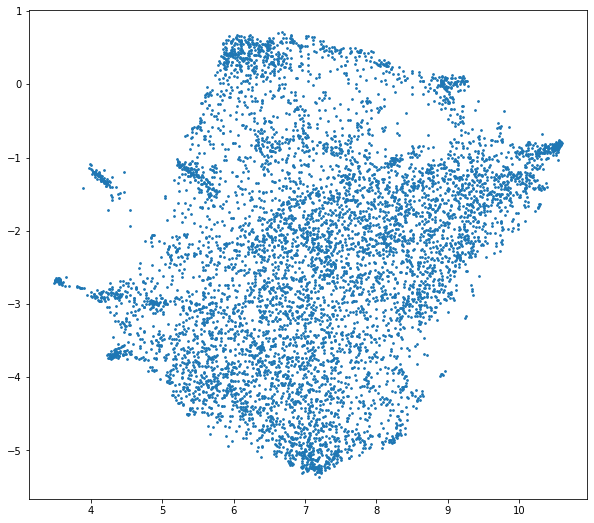

In [ ]:

import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [ ]:
products = train_df[["productid", "clean_name"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='productid', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('productid')['clean_name'].apply(list).to_dict()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# test the dictionary
products_dict['HBV00000NG8K2']


['billur tuz iyotlu tuz']

In [ ]:
len(products_dict)

#**Implement Cosine Similarity**

**Cosine similarity** *measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. It is often used to measure document similarity in text analysis.*


In [ ]:
def similar_products(v, n = 10):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms  

# **Test the model**

**Within the API recommendation, Products are going to  be shown seen as original name**

Billur Tuz İyotlu Tuz 750 gr

In [ ]:
similar_products(model['HBV00000NG8K2'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.


[('biosalt himalaya kaya tuzu iyotlu', 0.7177181243896484),
 ('carrefour pul kırmızı biber', 0.6684281826019287),
 ('tat domates salcası', 0.6632798910140991),
 ('carrefour gönen baldo pirinç', 0.6504337787628174),
 ('carrefour toz şeker', 0.6438308954238892),
 ('billur tuz iyotlu eko', 0.643634021282196),
 ('dr oetker pudra şekeri kilitli', 0.6372979879379272),
 ('koska üzüm pekmezi  cam kavanoz', 0.6364596486091614),
 ('carrefour patlatmalık mısır', 0.6339823007583618),
 ('carrefour domates salçası  teneke', 0.6313455104827881)]

Dana Kıyma (%5-%7 Yağ) 250 gr

In [ ]:

similar_products(model['HBV00000NVZE8'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.


[('dana sote', 0.752193808555603),
 ('limon lamas', 0.7235180735588074),
 ('kasap köfte', 0.7233253717422485),
 ('dana kıyma yağ', 0.7214622497558594),
 ('patates', 0.7150363922119141),
 ('maydanoz', 0.6955817937850952),
 ('ithal muz', 0.6916676759719849),
 ('dana kıyma yağ', 0.684658944606781),
 ('kıvırcık salata adet', 0.6829144954681396),
 ('roka', 0.6825013160705566)]

Raid Karınca Yemi 2 Adet

In [ ]:

similar_products(model['ZYJWAX638748'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.


[('raid elektro makine adet mat tablet', 0.6343850493431091),
 ('cillit bang mutfak temizleyici yağ kir sökücü sprey', 0.6216142177581787),
 ('orkid ultra extra uzun adet süper ekonomik paket hijyenik ped',
  0.6176348924636841),
 ('raid sineksavar kokusuz', 0.6044924855232239),
 ('bref power aktif lavanta pack', 0.5924785137176514),
 ('vileda candy pınk eldiven orta', 0.5890088677406311),
 ('cillit bang banyo temizleyici derz arası temizleyici sprey',
  0.5773043036460876),
 ('bingo oksijen çamaşır suyu çam kokulu', 0.5737238526344299),
 ('raid böceksavar max', 0.5700469017028809),
 ('sek quark sade', 0.5695458650588989)]

Noki Dosya Çıtçıtlı Evrak Zarfı Kırmızı 3101 T.

In [ ]:
#HBV00000PV7M3 parfüm deodorant
similar_products(model['OFIS3101-080'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.


[('fabercastell bls plastik beyaz silgi', 0.7609821557998657),
 ('fabercastell bls plastik silgi beyaz', 0.71661776304245),
 ('pakmaya kek harcı sade', 0.7110365629196167),
 ('prima bebek bezi premium care beden adet midi jumbo paket',
  0.6846659779548645),
 ('fabercastell renkli tükenmez kalem blister', 0.6834121346473694),
 ('dr oetker karbonat x', 0.6608338952064514),
 ('all joy mini jel floral buket', 0.6535912156105042),
 ('vaseline jel krem baby', 0.6498348712921143),
 ('u green  bitkisel çamaşır yumuşatıcısı', 0.6471740007400513),
 ('rotring tikky versatil uç', 0.6446813344955444)]

Lezita Çıtır Kova Piliç Parçaları Donuk 850 gr

In [ ]:

similar_products(model['HBV00000NG8QZ'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.


[('kocaman hamsi marine sarımsaklı', 0.6468069553375244),
 ('bizim mutfak domates çorbası', 0.588742733001709),
 ('basic diş fırçası tekli', 0.5786066055297852),
 ('banvit piliç schnitzel taze küvet', 0.569577157497406),
 ('aytaç çiftlik kokteyl sosis', 0.5595884323120117),
 ('torku acılı işıl işlem görmüş kangal sucuk açık', 0.5516694784164429),
 ('stevia sıvı tatlandırıcı', 0.5488613247871399),
 ('dardanel çıtır sardalya', 0.5454742908477783),
 ('banvit hindi bonfile tabaklı', 0.5396398901939392),
 ('dana sote', 0.5334513187408447)]

Uno Premium Çavdarlı & Karabuğdaylı 350 Gr

In [ ]:

similar_products(model['HBV00000NFHIL'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.


[('uno premium cok tahıllı sıyez ekmek', 0.6776732802391052),
 ('kıtır uno denge çiya tohumlu', 0.6536833047866821),
 ('kenton pudra şekeri', 0.6301538348197937),
 ('icım laktozsuz sut', 0.6182962656021118),
 ('parex fiore kova', 0.6152686476707458),
 ('papaz erik paket', 0.6127704381942749),
 ('fora sele siyah zeytin', 0.6116753816604614),
 ('doğadan tarçın karanfil çayı', 0.6036614179611206),
 ('şeftali paket', 0.6031372547149658),
 ('carrefour kavrulmuş fındık içi', 0.5972334146499634)]

#**save the model**

In [ ]:
with open("RecSys.pkl", 'wb') as file:  
    rec_model = pickle.dump(model, file)

rec_model

In [ ]:
df_cleaned = df[['sessionid','productid','clean_name']]
df_cleaned

#**Save the dataset**

In [ ]:
df_cleaned.to_csv('cleaned.csv')